🔍 Carregando dados de treino e teste...
✅ Treino carregado: (30288, 45)
✅ Teste carregado: (3787, 45)
⚠️ Removendo 6 features com correlação 1.0 com a label

🚀 Executando benchmark de classificadores...

✔️ Logistic Regression | F1 = 1.0000 | Acc = 1.0000 | ROC AUC = 1.0000
✔️ SVM (RBF) | F1 = 1.0000 | Acc = 1.0000 | ROC AUC = 1.0000
✔️ Decision Tree | F1 = 1.0000 | Acc = 1.0000 | ROC AUC = 1.0000
✔️ Random Forest | F1 = 1.0000 | Acc = 1.0000 | ROC AUC = 1.0000
✔️ Gradient Boosting | F1 = 1.0000 | Acc = 1.0000 | ROC AUC = 1.0000
✔️ HistGradientBoosting | F1 = 1.0000 | Acc = 1.0000 | ROC AUC = 1.0000
✔️ XGBoost | F1 = 1.0000 | Acc = 1.0000 | ROC AUC = 1.0000
✔️ LightGBM | F1 = 1.0000 | Acc = 1.0000 | ROC AUC = 1.0000

📁 Resultados salvos com sucesso em: benchmark_resultados.xlsx


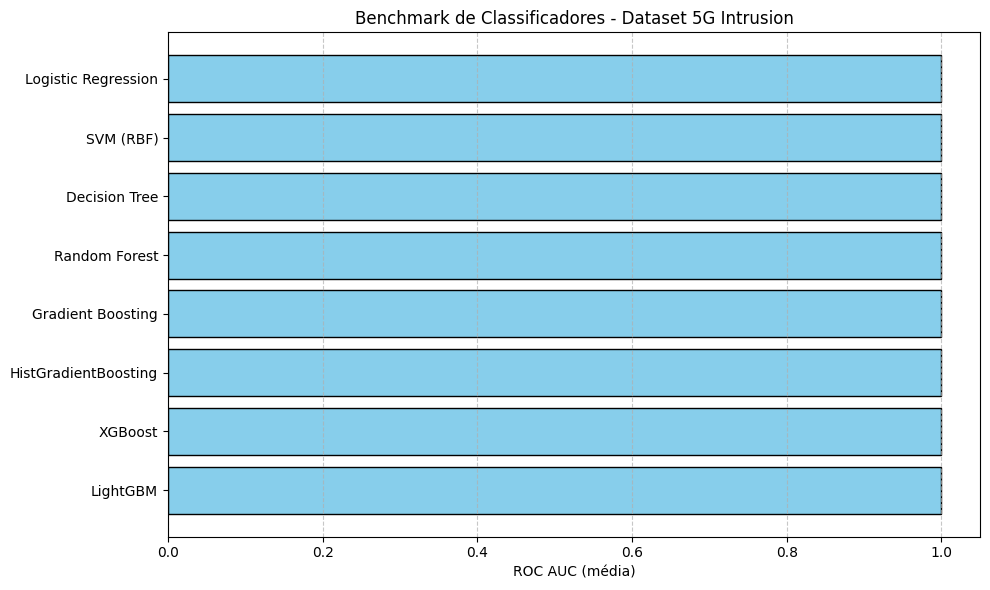

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier
import xgboost as xgb
import lightgbm as lgb

from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score

# =========================
# LEITURA DOS DADOS
# =========================
print("🔍 Carregando dados de treino e teste...")

df_train1 = pd.read_csv('../dataset/Train_subset_1.csv')
df_train2 = pd.read_csv('../dataset/Train_subset_2.csv')
df_train = pd.concat([df_train1, df_train2], ignore_index=True)
print("✅ Treino carregado:", df_train.shape)

df_test = pd.read_csv('data/Test_Data.csv')
print("✅ Teste carregado:", df_test.shape)

# =========================
# REMOVER FEATURES COM CORRELAÇÃO 1.0 COM LABEL
# =========================
cor_target = df_train.corr()['label'].abs().sort_values(ascending=False)
high_corr_feats = cor_target[cor_target == 1.0].index.tolist()
high_corr_feats.remove("label")

print(f"⚠️ Removendo {len(high_corr_feats)} features com correlação 1.0 com a label")
df_train_filtered = df_train.drop(columns=high_corr_feats)
df_test_filtered = df_test.drop(columns=high_corr_feats, errors='ignore')

# =========================
# SEPARAR FEATURES E LABELS
# =========================
X_train = df_train_filtered.drop(columns=["label"]).values
y_train = df_train_filtered["label"].values

X_test = df_test_filtered.drop(columns=["label"]).values
y_test = df_test_filtered["label"].values

# =========================
# FUNÇÃO DE BENCHMARK
# =========================
def run_full_benchmark(X, y, cv=5, random_state=42):
    models = {
        "Logistic Regression": LogisticRegression(max_iter=1000, random_state=random_state),
        "SVM (RBF)": SVC(kernel='rbf', probability=True, random_state=random_state),
        "Decision Tree": DecisionTreeClassifier(random_state=random_state),
        "Random Forest": RandomForestClassifier(n_estimators=100, random_state=random_state),
        "Gradient Boosting": GradientBoostingClassifier(random_state=random_state),
        "HistGradientBoosting": HistGradientBoostingClassifier(random_state=random_state),
        "XGBoost": xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=random_state),
        "LightGBM": lgb.LGBMClassifier(random_state=random_state)
    }

    scorers = {
        "accuracy": make_scorer(accuracy_score),
        "precision": make_scorer(precision_score),
        "recall": make_scorer(recall_score),
        "f1": make_scorer(f1_score),
        "roc_auc": make_scorer(roc_auc_score),
        "average_precision": make_scorer(average_precision_score)
    }

    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=random_state)
    results = []

    print("\n🚀 Executando benchmark de classificadores...\n")
    for name, model in models.items():
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('clf', model)
        ])
        row = {"Modelo": name}
        for metric, scorer in scorers.items():
            scores = cross_val_score(pipeline, X, y, cv=skf, scoring=scorer, n_jobs=-1)
            row[f"{metric}_mean"] = scores.mean()
            row[f"{metric}_std"] = scores.std()
        print(f"✔️ {name} | F1 = {row['f1_mean']:.4f} | Acc = {row['accuracy_mean']:.4f} | ROC AUC = {row['roc_auc_mean']:.4f}")
        results.append(row)

    return pd.DataFrame(results)

# =========================
# EXECUTA E ORGANIZA RESULTADOS
# =========================
df_results = run_full_benchmark(X_train, y_train)
df_results = df_results.sort_values(by="f1_mean", ascending=False)

# Salva em Excel
output_file = "benchmark_resultados.xlsx"
with pd.ExcelWriter(output_file, engine='openpyxl') as writer:
    df_results.to_excel(writer, sheet_name="Benchmark", index=False)

print(f"\n📁 Resultados salvos com sucesso em: {output_file}")

# =========================
# GRÁFICO DE ROC AUC
# =========================
plt.figure(figsize=(10, 6))
plt.barh(
    df_results["Modelo"],
    df_results["roc_auc_mean"],
    xerr=df_results["roc_auc_std"],
    color='skyblue',
    edgecolor='black'
)
plt.xlabel("ROC AUC (média)")
plt.title("Benchmark de Classificadores - Dataset 5G Intrusion")
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [7]:
df_results

,Modelo,accuracy_mean,accuracy_std,precision_mean,precision_std,recall_mean,recall_std,f1_mean,f1_std,roc_auc_mean,roc_auc_std,average_precision_mean,average_precision_std
0,Logistic Regression,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1,SVM (RBF),1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2,Decision Tree,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
3,Random Forest,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
4,Gradient Boosting,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
5,HistGradientBoosting,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
6,XGBoost,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
7,LightGBM,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0


In [8]:
print(df_train_filtered.sample(5).T)


                                         11858         13145         1107   \
ip.len                            1.040000e+02  1.040000e+02    104.000000   
ip.flags.df                       1.000000e+00  1.000000e+00      1.000000   
ip.flags.mf                       0.000000e+00  0.000000e+00      0.000000   
tcp.port                          8.000000e+01  8.000000e+01  35076.000000   
tcp.window_size                   0.000000e+00  0.000000e+00      0.000000   
tcp.ack_raw                       3.099783e+09  2.461074e+09      0.000000   
ip.fragment                       0.000000e+00  0.000000e+00      0.000000   
ip.fragment.count                 0.000000e+00  0.000000e+00      0.000000   
ip.fragments                      0.000000e+00  0.000000e+00      0.000000   
ip.ttl                            6.400000e+01  6.400000e+01     64.000000   
ip.proto                          1.700000e+01  1.700000e+01     17.000000   
tcp.window_size.1                 2.896000e+04  6.553500e+04  64

In [9]:
from sklearn.metrics import classification_report

# Exemplo com o melhor modelo
model = LogisticRegression(max_iter=1000).fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2987
           1       1.00      1.00      1.00       800

    accuracy                           1.00      3787
   macro avg       1.00      1.00      1.00      3787
weighted avg       1.00      1.00      1.00      3787



🔍 Lendo dados...
🔴 Removendo 9 variáveis com corr > 0.99:
['ip.flags.df', 'gtp.ext_hdr', 'gtp.ext_hdr.length', 'gtp.ext_hdr.pdu_ses_con.qos_flow_id', 'gtp.flags', 'gtp.flags.e', 'gtp.flags.payload', 'gtp.flags.version', 'gtp.message']

🚀 Executando benchmark com StratifiedKFold...

🧪 Avaliando modelo: Logistic Regression
Fold 1: F1=1.0000, Acc=1.0000, ROC AUC=1.0000
Fold 2: F1=1.0000, Acc=1.0000, ROC AUC=1.0000
Fold 3: F1=1.0000, Acc=1.0000, ROC AUC=1.0000
Fold 4: F1=0.9996, Acc=0.9998, ROC AUC=1.0000
Fold 5: F1=1.0000, Acc=1.0000, ROC AUC=1.0000
🧪 Avaliando modelo: SVM (RBF)
Fold 1: F1=1.0000, Acc=1.0000, ROC AUC=1.0000
Fold 2: F1=1.0000, Acc=1.0000, ROC AUC=1.0000
Fold 3: F1=1.0000, Acc=1.0000, ROC AUC=1.0000
Fold 4: F1=0.9996, Acc=0.9998, ROC AUC=1.0000
Fold 5: F1=1.0000, Acc=1.0000, ROC AUC=1.0000
🧪 Avaliando modelo: Decision Tree
Fold 1: F1=1.0000, Acc=1.0000, ROC AUC=1.0000
Fold 2: F1=1.0000, Acc=1.0000, ROC AUC=1.0000
Fold 3: F1=1.0000, Acc=1.0000, ROC AUC=1.0000
Fold 4: F1=1.00

c:\Users\niels\anaconda3\envs\pesquisa\Lib\site-packages\xgboost\core.py:158: UserWarning: [11:18:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\niels\anaconda3\envs\pesquisa\Lib\site-packages\xgboost\core.py:158: UserWarning: [11:18:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\niels\anaconda3\envs\pesquisa\Lib\site-packages\xgboost\core.py:158: UserWarning: [11:18:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c

Fold 1: F1=1.0000, Acc=1.0000, ROC AUC=1.0000
Fold 2: F1=1.0000, Acc=1.0000, ROC AUC=1.0000
Fold 3: F1=1.0000, Acc=1.0000, ROC AUC=1.0000
Fold 4: F1=1.0000, Acc=1.0000, ROC AUC=1.0000
Fold 5: F1=1.0000, Acc=1.0000, ROC AUC=1.0000
🧪 Avaliando modelo: LightGBM
[LightGBM] [Info] Number of positive: 5120, number of negative: 19110
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000494 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1309
[LightGBM] [Info] Number of data points in the train set: 24230, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211308 -> initscore=-1.317057
[LightGBM] [Info] Start training from score -1.317057
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

c:\Users\niels\anaconda3\envs\pesquisa\Lib\site-packages\xgboost\core.py:158: UserWarning: [11:18:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

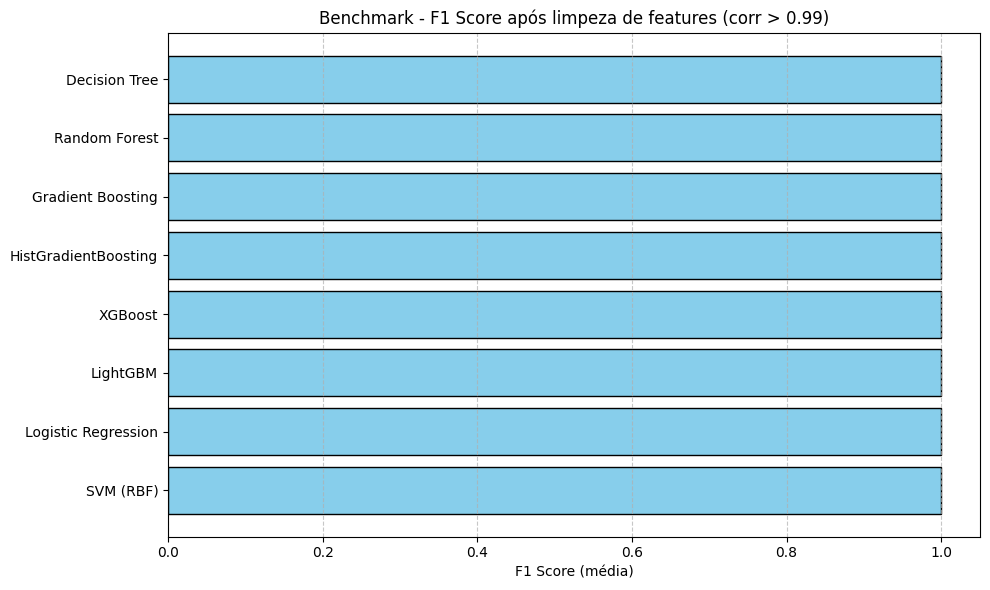

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, average_precision_score
)

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier
)
import xgboost as xgb
import lightgbm as lgb

# ======================
# 1. LEITURA DOS DADOS
# ======================
print("🔍 Lendo dados...")

df1 = pd.read_csv('../dataset/Train_subset_1.csv')
df2 = pd.read_csv('../dataset/Train_subset_2.csv')
df_train = pd.concat([df1, df2], ignore_index=True)

df_test = pd.read_csv('../dataset/Test_Data.csv')

# ======================
# 2. REMOVER VARIÁVEIS COM CORRELAÇÃO > 0.99
# ======================
cor_target = df_train.corr()['label'].abs()
variaveis_suspeitas = cor_target[(cor_target > 0.99) & (cor_target.index != 'label')].index.tolist()

print(f"🔴 Removendo {len(variaveis_suspeitas)} variáveis com corr > 0.99:")
print(variaveis_suspeitas)

df_train = df_train.drop(columns=variaveis_suspeitas)
df_test = df_test.drop(columns=variaveis_suspeitas, errors='ignore')

selected_features = [
    'ip.proto',
    'ip.ttl',
    'frame.time_relative',
    'tcp.flags',
    'tcp.port',
    'ip.len',
    'udp.length',
    'gtp.teid',
    'tcp.seq',
    'tcp.ack_raw',
    'tcp.window_size',
    'tcp.analysis.ack_rtt'
]



# ======================
# 3. SEPARAR X E y
# ======================
# X = df_train.drop(columns=['label']).values
X = df_train[selected_features]
y = df_train['label'].values

# ======================
# 4. DEFINIR MODELOS
# ======================
modelos = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "SVM (RBF)": SVC(kernel='rbf', probability=True, random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "HistGradientBoosting": HistGradientBoostingClassifier(random_state=42),
    "XGBoost": xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    "LightGBM": lgb.LGBMClassifier(random_state=42)
}

# ======================
# 5. FUNÇÃO DE AVALIAÇÃO COM K-FOLD
# ======================
def evaluate_model_cv(model, X, y, cv=5, random_state=42):
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=random_state)
    metrics = {
        "accuracy": [], "precision": [], "recall": [],
        "f1": [], "roc_auc": [], "average_precision": []
    }

    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y), 1):
        # X_train, X_val = X[train_idx], X[val_idx]
        # y_train, y_val = y[train_idx], y[val_idx]
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]


        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('clf', model)
        ])
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_val)
        y_prob = pipeline.predict_proba(X_val)[:, 1] if hasattr(pipeline.named_steps['clf'], "predict_proba") else y_pred

        metrics["accuracy"].append(accuracy_score(y_val, y_pred))
        metrics["precision"].append(precision_score(y_val, y_pred))
        metrics["recall"].append(recall_score(y_val, y_pred))
        metrics["f1"].append(f1_score(y_val, y_pred))
        metrics["roc_auc"].append(roc_auc_score(y_val, y_prob))
        metrics["average_precision"].append(average_precision_score(y_val, y_prob))

        print(f"Fold {fold}: F1={metrics['f1'][-1]:.4f}, Acc={metrics['accuracy'][-1]:.4f}, ROC AUC={metrics['roc_auc'][-1]:.4f}")

    result = {f"{k}_mean": np.mean(v) for k, v in metrics.items()}
    result.update({f"{k}_std": np.std(v) for k, v in metrics.items()})
    return result

# ======================
# 6. EXECUTAR BENCHMARK
# ======================
print("\n🚀 Executando benchmark com StratifiedKFold...\n")

resultados = []
for nome, modelo in modelos.items():
    print(f"🧪 Avaliando modelo: {nome}")
    resumo = evaluate_model_cv(modelo, X, y, cv=5)
    resumo["Modelo"] = nome
    resumo["Num_Features"] = X.shape[1]
    resultados.append(resumo)

# ======================
# 7. SALVAR RESULTADOS
# ======================
df_resultados = pd.DataFrame(resultados)
df_resultados = df_resultados.sort_values(by="f1_mean", ascending=False)

excel_path = "../results/benchmark_kfold_resultados_selecao_feastures.xlsx"
df_resultados.to_excel(excel_path, index=False)
print(f"\n📊 Resultados salvos com sucesso em: {excel_path}")

# ======================
# 8. GRÁFICO DE F1-SCORE
# ======================
plt.figure(figsize=(10, 6))
plt.barh(
    df_resultados["Modelo"],
    df_resultados["f1_mean"],
    xerr=df_resultados["f1_std"],
    color='skyblue',
    edgecolor='black'
)
plt.xlabel("F1 Score (média)")
plt.title("Benchmark - F1 Score após limpeza de features (corr > 0.99)")
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [40]:
df_resultados

,accuracy_mean,precision_mean,recall_mean,f1_mean,roc_auc_mean,average_precision_mean,accuracy_std,precision_std,recall_std,f1_std,roc_auc_std,average_precision_std,Modelo,Num_Features
2,1.000000,1.0,1.000000,1.000000,1.0,1.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000e+00,Decision Tree,12
3,1.000000,1.0,1.000000,1.000000,1.0,1.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000e+00,Random Forest,12
4,1.000000,1.0,1.000000,1.000000,1.0,1.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000e+00,Gradient Boosting,12
5,1.000000,1.0,1.000000,1.000000,1.0,1.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000e+00,HistGradientBoosting,12
6,1.000000,1.0,1.000000,1.000000,1.0,1.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000e+00,XGBoost,12
7,1.000000,1.0,1.000000,1.000000,1.0,1.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000e+00,LightGBM,12
0,0.999967,1.0,0.999844,0.999922,1.0,1.0,0.000066,0.0,0.000312,0.000156,0.0,0.000000e+00,Logistic Regression,12
1,0.999967,1.0,0.999844,0.999922,1.0,1.0,0.000066,0.0,0.000312,0.000156,0.0,4.965068e-17,SVM (RBF),12


In [33]:
cor_target = df_train.corr()['label'].abs()
variaveis_suspeitas = cor_target[(cor_target > 0.95) & (cor_target.index != 'label')].index.tolist()
df_train = df_train.drop(columns=variaveis_suspeitas)
df_test = df_test.drop(columns=variaveis_suspeitas, errors='ignore')


In [35]:
cor_target = df_train.corr()['label'].abs()
print(cor_target.sort_values(ascending=False))


label                               1.000000
ip.proto                            0.663544
ip.ttl                              0.625848
frame.time_relative                 0.533765
tcp.flags                           0.533017
gtp.teid                            0.461499
gtp.ext_hdr.pdu_ses_con.pdu_type    0.454805
tcp.stream                          0.454361
tcp.ack_raw                         0.413380
tcp.port                            0.353322
udp.length                          0.296687
ip.len                              0.287611
gtp.length                          0.271759
tcp.analysis.ack_rtt                0.166278
tcp.window_size.1                   0.158826
tcp.len                             0.120112
http.request                        0.119643
tcp.segments                        0.057876
tcp.reassembled.length              0.055627
tcp.seq                             0.052956
udp.port                            0.040897
tcp.ack                             0.039412
frame.time

In [22]:
# ! pip install shap

c:\Users\niels\anaconda3\envs\pesquisa\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[LightGBM] [Info] Number of positive: 5120, number of negative: 19110
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001212 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2880
[LightGBM] [Info] Number of data points in the train set: 24230, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211308 -> initscore=-1.317057
[LightGBM] [Info] Start training from score -1.317057
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

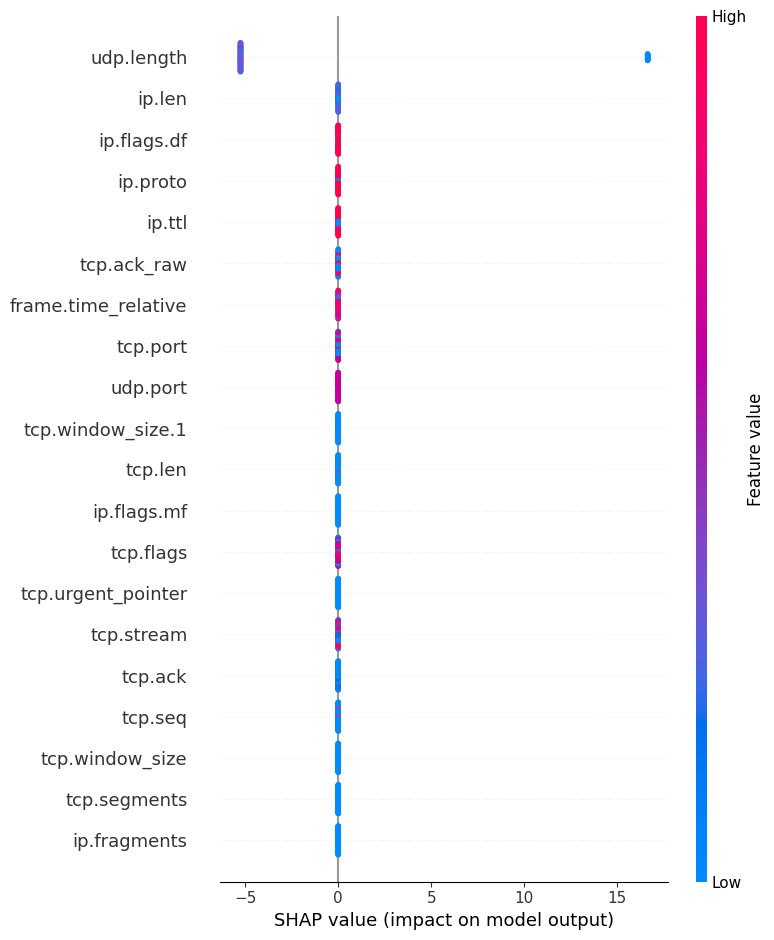

In [ ]:
import shap
import pandas as pd
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 1. Carregando os datasets de treino
df_train1 = pd.read_csv('../dataset/Train_subset_1.csv')
df_train2 = pd.read_csv('../dataset/Train_subset_2.csv')
df_train = pd.concat([df_train1, df_train2], ignore_index=True)

# 2. Separando features e rótulo
X = df_train.drop(columns=['label'])
y = df_train['label']

# 3. Padronização
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 4. Separando treino e validação
X_train, X_val, y_train, y_val = train_test_split(
    X_scaled, y, stratify=y, test_size=0.2, random_state=42
)

# 5. Treinando o modelo LightGBM
model = lgb.LGBMClassifier()
model.fit(X_train, y_train)

# 6. Criando explainer SHAP
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_val[:100])  # Apenas 100 amostras para visualização

# 7. Gerando gráfico de resumo
plt.figure(figsize=(12, 6))
shap.summary_plot(shap_values, features=X_val[:100], feature_names=X.columns.tolist(), show=False)
plt.tight_layout()
plt.show()


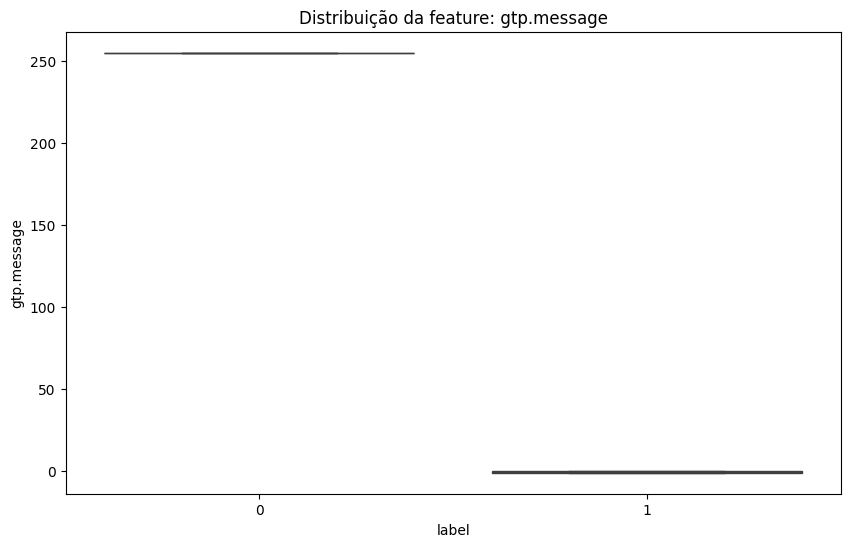

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

top_feat = 'gtp.message'
plt.figure(figsize=(10,6))
sns.boxplot(x='label', y=top_feat, data=df_train)
plt.title(f'Distribuição da feature: {top_feat}')
plt.show()


## **1️⃣ Identificação e contexto da conexão**

* **`ip.proto`** – Protocolo de transporte (TCP, UDP, ICMP etc.). Mudanças inesperadas na proporção de protocolos podem indicar anomalias.
* **`tcp.port` / `udp.port`** – Portas de origem/destino. Ataques costumam usar portas incomuns ou varreduras rápidas.
* **`ip.ttl`** – Tempo de vida do pacote. TTLs muito baixos ou diferentes do esperado podem indicar spoofing.
* **`frame.time_relative`** – Momento relativo do pacote. Picos ou padrões temporais incomuns são indicativos.
* **`ip.len` / `udp.length` / `gtp.length`** – Tamanho do pacote; pacotes muito grandes ou muito pequenos podem indicar ataques (DoS, exfiltração de dados).
* **`gtp.teid`** – Em redes 5G/LTE, o identificador de túnel GTP ajuda a correlacionar sessões.

---

## **2️⃣ Comportamento do TCP**

* **`tcp.flags`** – Bits como SYN, ACK, FIN, RST. Padrões anormais (muitos SYN sem ACK → SYN flood).
* **`tcp.stream`** – Número do fluxo; pode ser usado para agrupar pacotes.
* **`tcp.ack_raw` / `tcp.seq`** – Análise de sequência/ACK pode indicar hijacking ou retransmissões excessivas.
* **`tcp.len`** – Comprimento dos dados TCP; pacotes vazios em excesso (sem payload) podem indicar escaneamento.
* **`tcp.window_size`** – Janela de recepção; valores anômalos podem sinalizar ataques de lentidão (Slowloris).
* **`tcp.analysis.ack_rtt`** – Tempo de resposta ACK; atrasos incomuns podem ser indicativos de congestão ou ataques.

---

## **3️⃣ Temporalidade e frequência**

* **`frame.time_delta`** – Diferença de tempo entre pacotes; picos e rajadas são sinais de possíveis ataques.
* **`tcp.time_relative` / `tcp.time_delta`** – Útil para detectar flood ou conexões lentas.
* **Contagem de pacotes** por fluxo/conexão (pode ser derivada).

---

## **4️⃣ Indicadores específicos de aplicação**

* **`http.request`** – Presença de requisições HTTP; um número alto pode indicar ataques de aplicação (DDoS camada 7).
* **`tcp.reassembled.length`** / **`tcp.segments`** – Reassembly de dados TCP pode mostrar transferências grandes (exfiltração de dados).

---

## **5️⃣ Campos específicos de redes móveis (GTP/5G)**

* **`gtp.ext_hdr.pdu_ses_con.pdu_type`** – Tipo de PDU; mudanças podem indicar ataques na camada de controle.
* **`gtp.ext_hdr.pdu_ses_cont.ppp`**, `rqi`, `pn`, `reserved` – Usados para análise forense em 5G.
* **Anomalias no TEID** (muitos TEIDs novos em pouco tempo) → possível abuso de sessão.




